# Stanford CS230 Traffic Sign Project

In [1]:
!nvidia-smi

Tue Oct 27 06:18:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.3
torch 1.6.0+cu101
torchvision 0.7.0+cu101


In [4]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Traffic Signs

We are using [German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) which contains more than 50,000 annotated images of 40+ traffic signs.


In [5]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-10-27 06:18:24--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  4.34MB/s    in 62s     

2020-10-27 06:19:27 (4.24 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



## Exploration

### Checking Folders and Files

In [6]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (73.4 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 144611 files and directories currently instal

In [7]:
!tree GTSRB --filelimit=50

GTSRB
├── Final_Training
│   └── Images
│       ├── 00000 [211 entries exceeds filelimit, not opening dir]
│       ├── 00001 [2221 entries exceeds filelimit, not opening dir]
│       ├── 00002 [2251 entries exceeds filelimit, not opening dir]
│       ├── 00003 [1411 entries exceeds filelimit, not opening dir]
│       ├── 00004 [1981 entries exceeds filelimit, not opening dir]
│       ├── 00005 [1861 entries exceeds filelimit, not opening dir]
│       ├── 00006 [421 entries exceeds filelimit, not opening dir]
│       ├── 00007 [1441 entries exceeds filelimit, not opening dir]
│       ├── 00008 [1411 entries exceeds filelimit, not opening dir]
│       ├── 00009 [1471 entries exceeds filelimit, not opening dir]
│       ├── 00010 [2011 entries exceeds filelimit, not opening dir]
│       ├── 00011 [1321 entries exceeds filelimit, not opening dir]
│       ├── 00012 [2101 entries exceeds filelimit, not opening dir]
│       ├── 00013 [2161 entries exceeds filelimit, not opening dir]
│       ├─

In [8]:
!ls GTSRB/Final_Training/Images/00000 -U | head -5

00002_00002.ppm
00001_00015.ppm
00003_00025.ppm
00003_00000.ppm
00002_00016.ppm


### Checking Readme

In [9]:
with open('GTSRB/Readme-Images.txt', encoding='windows-1252') as f:
    print(f.read())

**********************************************
The German Traffic Sign Recognition Benchmark
**********************************************

This archive contains the training set of the 
"German Traffic Sign Recognition Benchmark".

This training set is supposed be used for the online competition 
as part of the IJCNN 2011 competition. It is a subset of the final
training set that will be published after the online competition is
closed. 


**********************************************
Archive content
**********************************************
This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The

### Checking Images

In [10]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
print(train_folders)
len(train_folders)

['GTSRB/Final_Training/Images/00000', 'GTSRB/Final_Training/Images/00001', 'GTSRB/Final_Training/Images/00002', 'GTSRB/Final_Training/Images/00003', 'GTSRB/Final_Training/Images/00004', 'GTSRB/Final_Training/Images/00005', 'GTSRB/Final_Training/Images/00006', 'GTSRB/Final_Training/Images/00007', 'GTSRB/Final_Training/Images/00008', 'GTSRB/Final_Training/Images/00009', 'GTSRB/Final_Training/Images/00010', 'GTSRB/Final_Training/Images/00011', 'GTSRB/Final_Training/Images/00012', 'GTSRB/Final_Training/Images/00013', 'GTSRB/Final_Training/Images/00014', 'GTSRB/Final_Training/Images/00015', 'GTSRB/Final_Training/Images/00016', 'GTSRB/Final_Training/Images/00017', 'GTSRB/Final_Training/Images/00018', 'GTSRB/Final_Training/Images/00019', 'GTSRB/Final_Training/Images/00020', 'GTSRB/Final_Training/Images/00021', 'GTSRB/Final_Training/Images/00022', 'GTSRB/Final_Training/Images/00023', 'GTSRB/Final_Training/Images/00024', 'GTSRB/Final_Training/Images/00025', 'GTSRB/Final_Training/Images/00026', 

43

3 helper functions that use OpenCV and Torchvision to load  and show images:

In [11]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)

  # <batch size, image height, image width, image channel> respectively.
  # In Pytorch, the input channel should be in the second dimension. That's why the permutation is required.
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Some examples

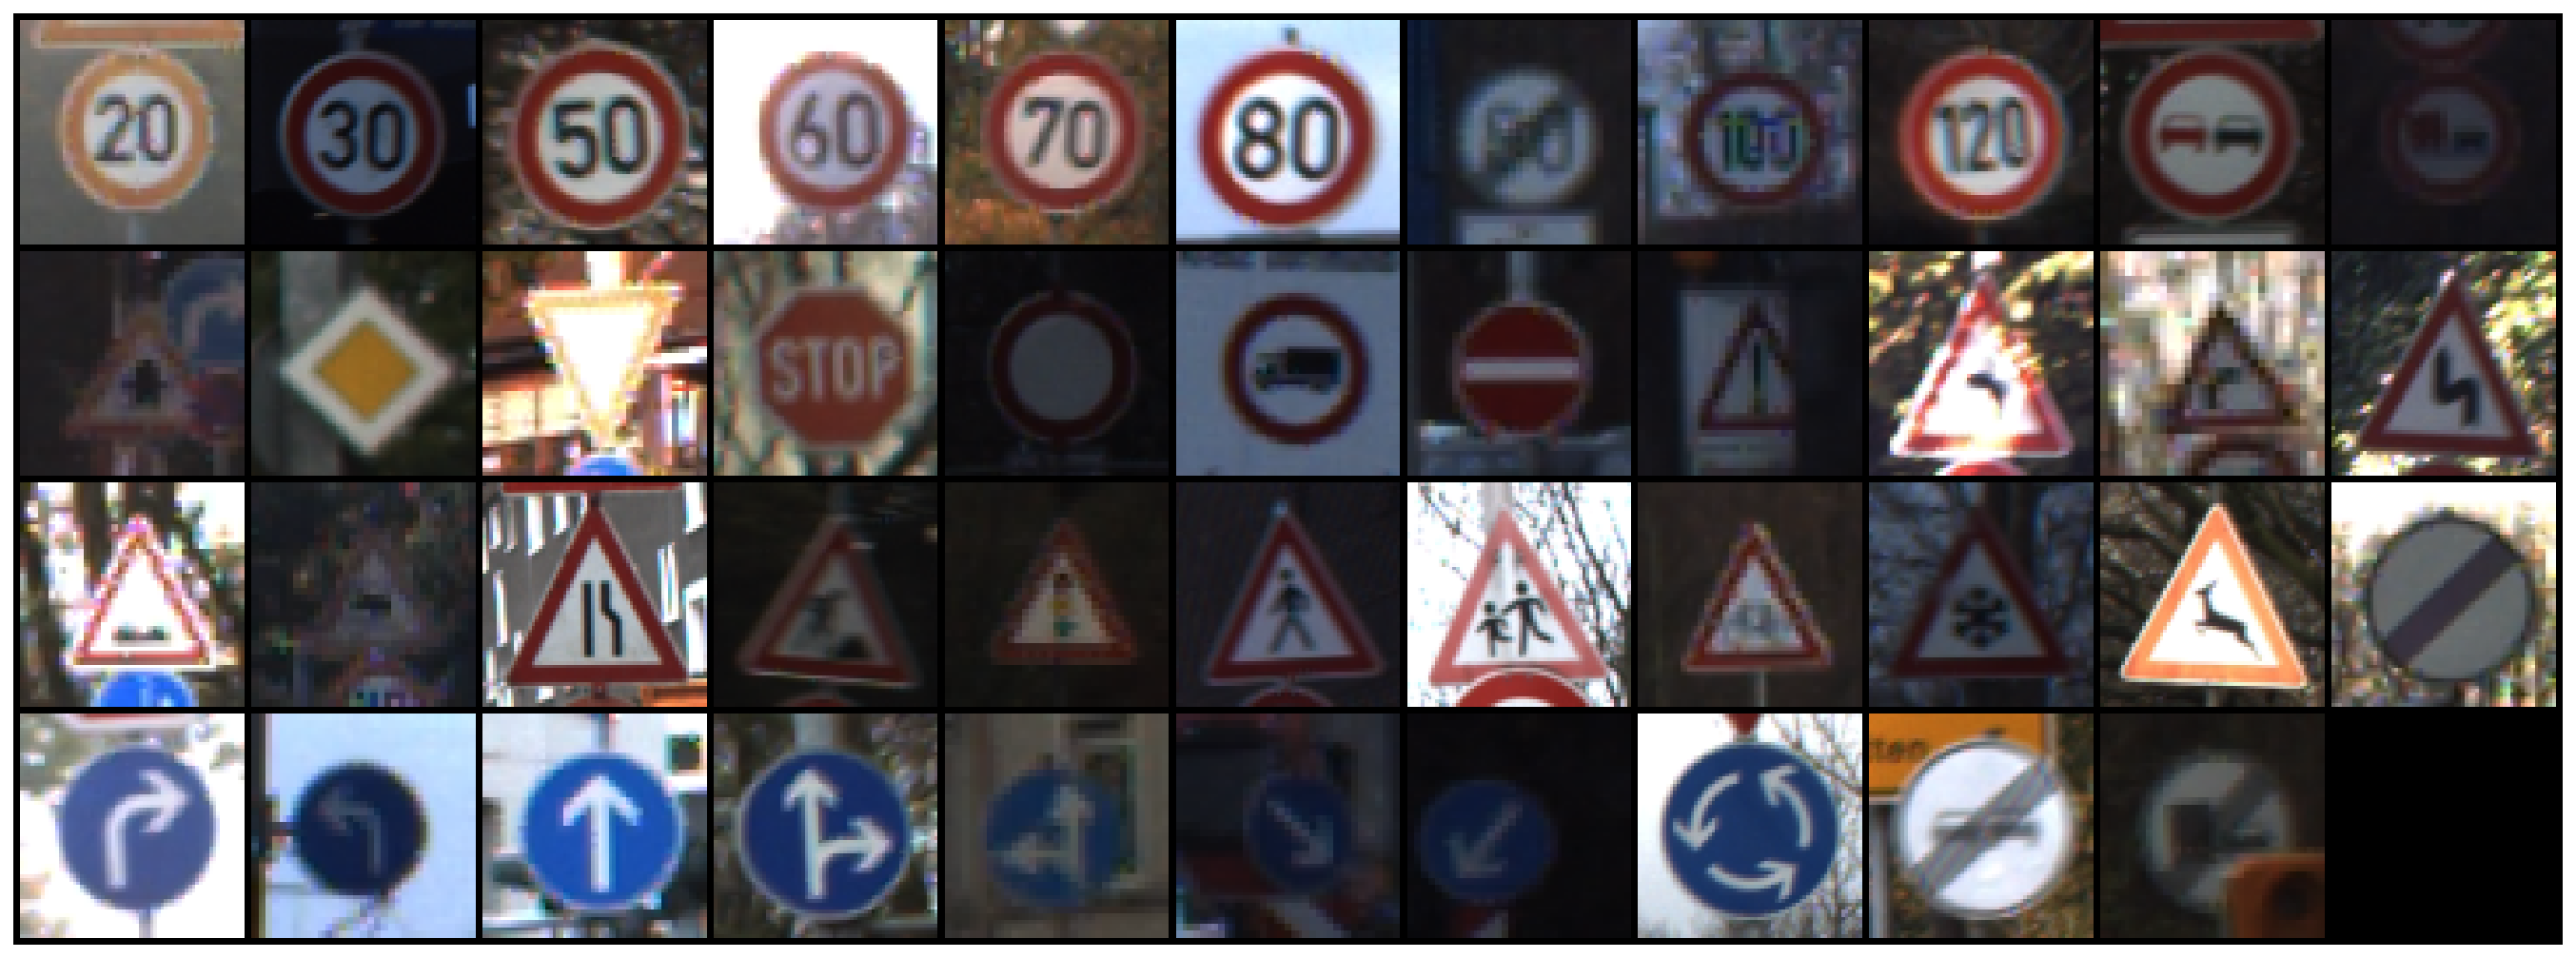

In [12]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

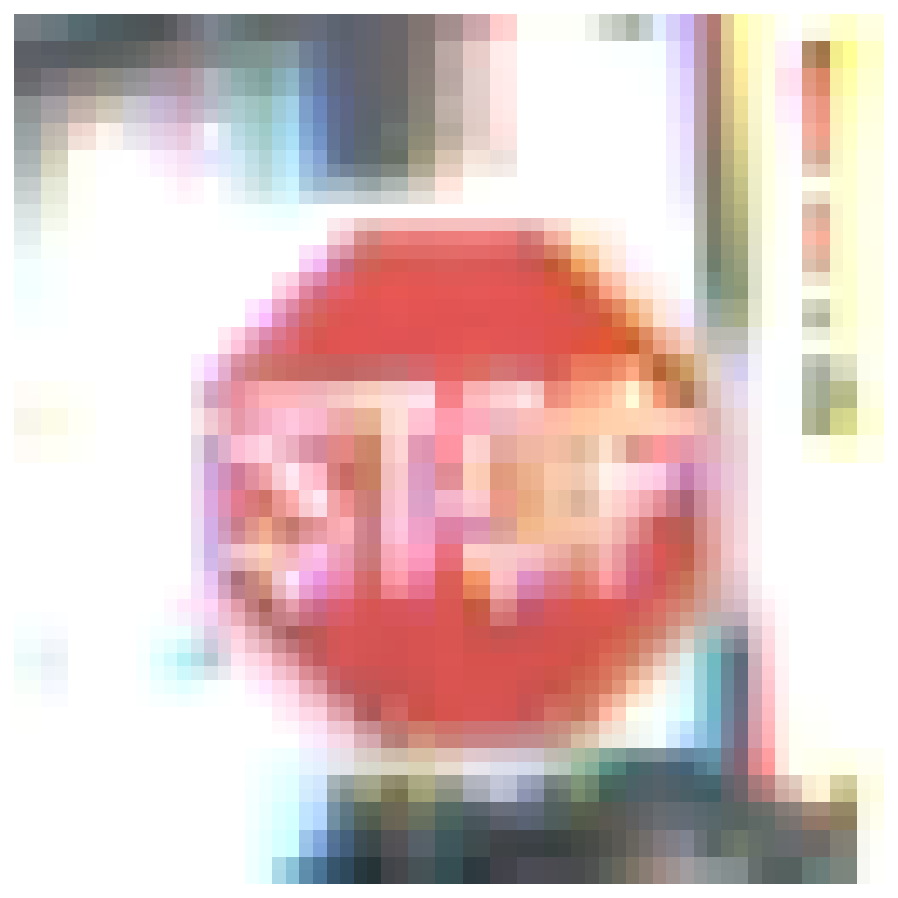

In [13]:
img_path = glob(f'{train_folders[14]}/*ppm')[0]
show_image(img_path)

## Building a dataset

Classifying some of the most used traffic signs:

In [14]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

In [15]:
!rm -rf data

DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

for dataset in DATASETS:
  for class_name in class_names:
    (DATA_DIR / dataset / class_name).mkdir(parents=True, exist_ok=True)

In [16]:
!tree data --filelimit=100

data
├── test
│   ├── give_way
│   ├── no_entry
│   ├── priority_road
│   └── stop
├── train
│   ├── give_way
│   ├── no_entry
│   ├── priority_road
│   └── stop
└── val
    ├── give_way
    ├── no_entry
    ├── priority_road
    └── stop

15 directories, 0 files


We reserve 80% of the images for training, 10% for validation, and 10% test for each class.

Copy each image to the correct dataset directory:

In [17]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  dataset_split = np.split(
    image_paths,
    # 80% of the images for training, 10% for validation, and 10% test for each class
    indices_or_sections=[int(0.8 * len(image_paths)), int(0.9 * len(image_paths))])

  dataset_data = zip(DATASETS, dataset_split)

  for dataset, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{dataset}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [18]:
!tree data --filelimit=50

data
├── test
│   ├── give_way [216 entries exceeds filelimit, not opening dir]
│   ├── no_entry [111 entries exceeds filelimit, not opening dir]
│   ├── priority_road [210 entries exceeds filelimit, not opening dir]
│   └── stop [78 entries exceeds filelimit, not opening dir]
├── train
│   ├── give_way [1728 entries exceeds filelimit, not opening dir]
│   ├── no_entry [888 entries exceeds filelimit, not opening dir]
│   ├── priority_road [1680 entries exceeds filelimit, not opening dir]
│   └── stop [624 entries exceeds filelimit, not opening dir]
└── val
    ├── give_way [216 entries exceeds filelimit, not opening dir]
    ├── no_entry [111 entries exceeds filelimit, not opening dir]
    ├── priority_road [210 entries exceeds filelimit, not opening dir]
    └── stop [78 entries exceeds filelimit, not opening dir]

15 directories, 0 files


In [19]:
!ls data/train/stop -U | head -5

00002_00002.ppm
00016_00016.ppm
00010_00002.ppm
00001_00015.ppm
00018_00021.ppm


In [20]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {
  'train': T.Compose([
    T.RandomResizedCrop(size=256),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
  ]),
  'val': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
  ]),
  'test': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
  ])
}

In [21]:
image_datasets = {
  ds: ImageFolder(f'{DATA_DIR}/{ds}', transforms[ds]) for ds in DATASETS
}

data_loaders = {
  ds: DataLoader(image_datasets[ds], batch_size=4, shuffle=True, num_workers=4) for ds in DATASETS
}

We'll also store the number of examples in each dataset and class names for later:

In [22]:
dataset_sizes = {ds: len(image_datasets[ds]) for ds in DATASETS}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 4920, 'val': 615, 'test': 615}
['give_way', 'no_entry', 'priority_road', 'stop']


Let's have a look at some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data:

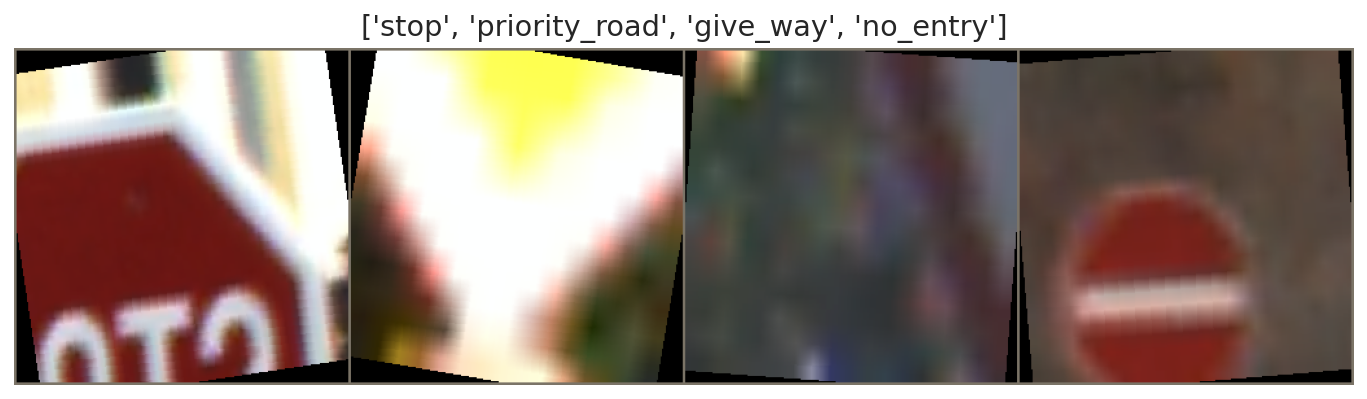

In [110]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using a pre-trained model

Our model will receive raw image pixels and try to classify them into one of four traffic signs. How hard can it be? Try to build a model from scratch.

Here, we'll use [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) to copy the architecture of the very popular [ResNet](https://arxiv.org/abs/1512.03385) model. On top of that, we'll use the learned weights of the model from training on the [ImageNet dataset ](http://www.image-net.org/). All of this is made easy to use by Torchvision:

In [24]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

We reuse almost everything except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

Let's create an instance of our model:

In [25]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


### Training

We'll write 3 helper functions to encapsulate the training and evaluation logic. Let's start with `train_epoch`:

In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

We start by turning our model into train mode and go over the data. After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

Note that we're also using a learning rate scheduler (more on that later).

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

The evaluation of the model is pretty similar, except that we don't do any gradient calculations.

Let's put everything together:

In [28]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

We do a lot of string formatting and recording of the training history. The hard stuff gets delegated to the previous helper functions. We also want the best model, so the weights of the most accurate model(s) get stored during the training.

Let's train our first model:

In [29]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.3190421468545508 accuracy 0.8916666666666667
Val   loss 0.006662659779957627 accuracy 1.0

Epoch 2/3
----------
Train loss 0.1276600865638383 accuracy 0.9601626016260163
Val   loss 0.002055348273464525 accuracy 0.9983739837398374

Epoch 3/3
----------
Train loss 0.10423182172680236 accuracy 0.9695121951219512
Val   loss 0.0011023832756304078 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 1min 52s, sys: 30.3 s, total: 2min 22s
Wall time: 2min 27s


Here's a little helper function that visualizes the training history for us:

In [30]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

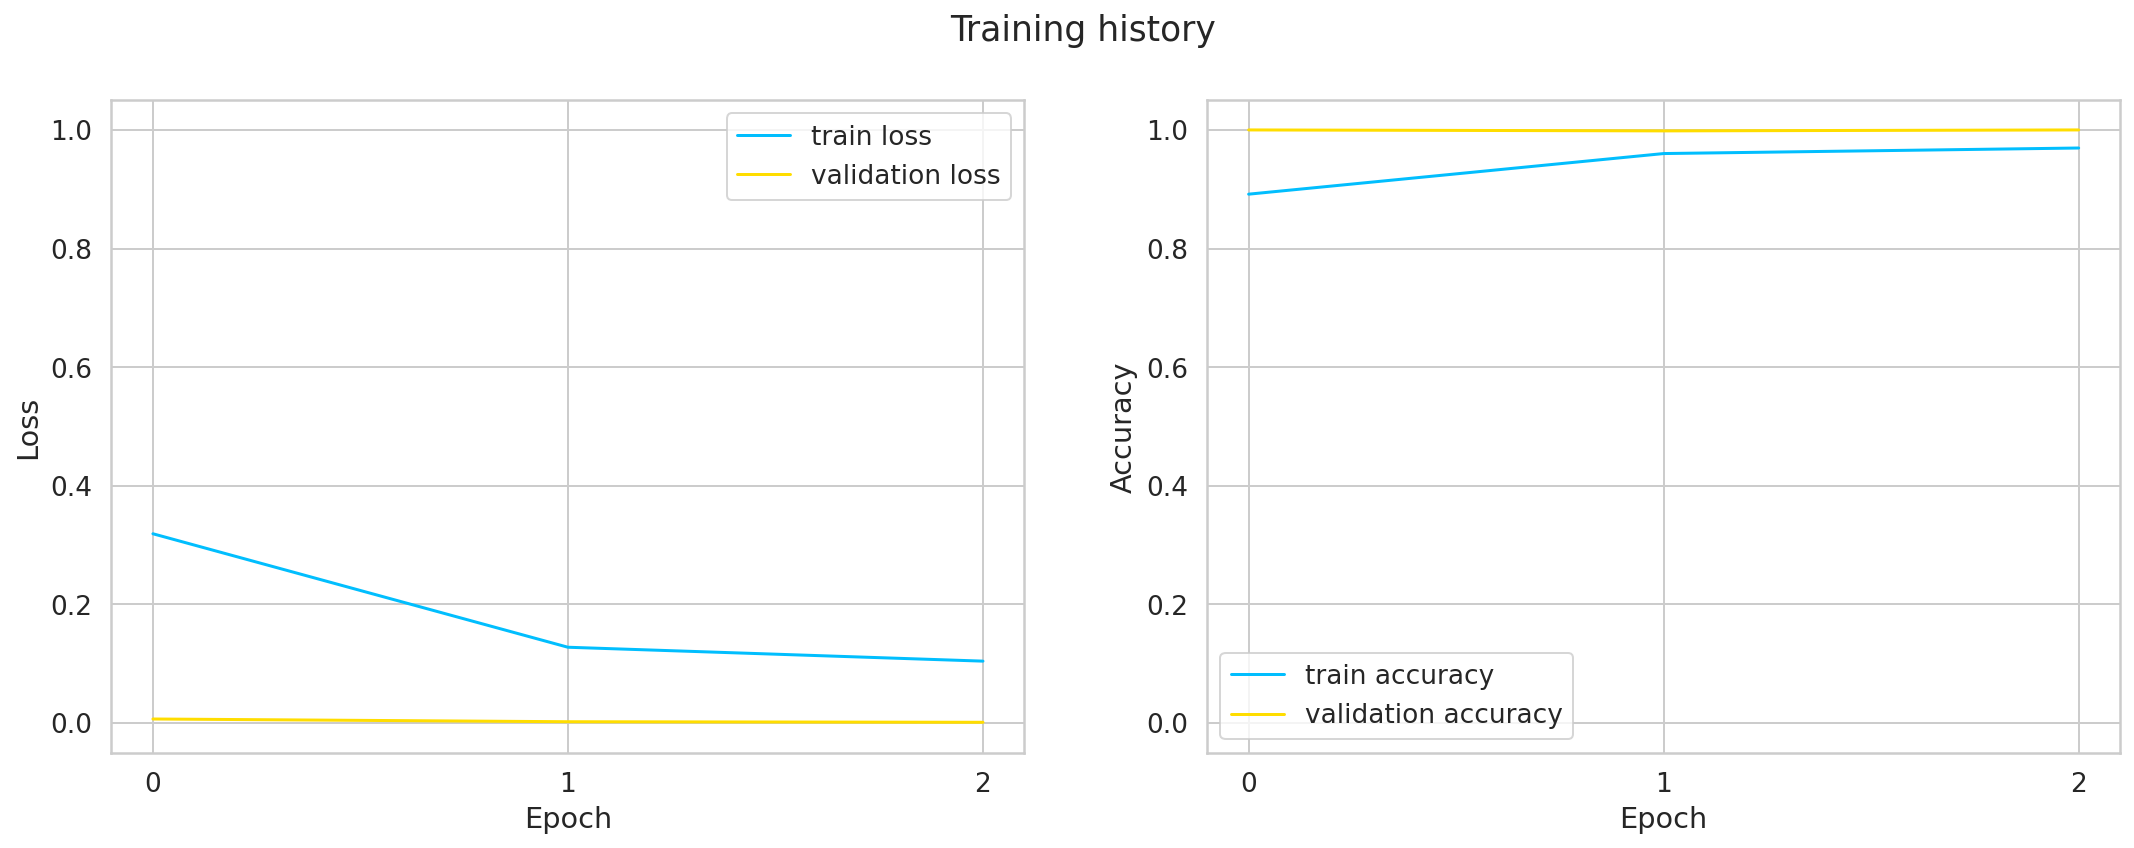

In [31]:
plot_training_history(history)

The pre-trained model is so good that we get very high accuracy and low loss after 3 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

### Evaluation

Let's see some predictions on traffic signs from the test set:

In [32]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

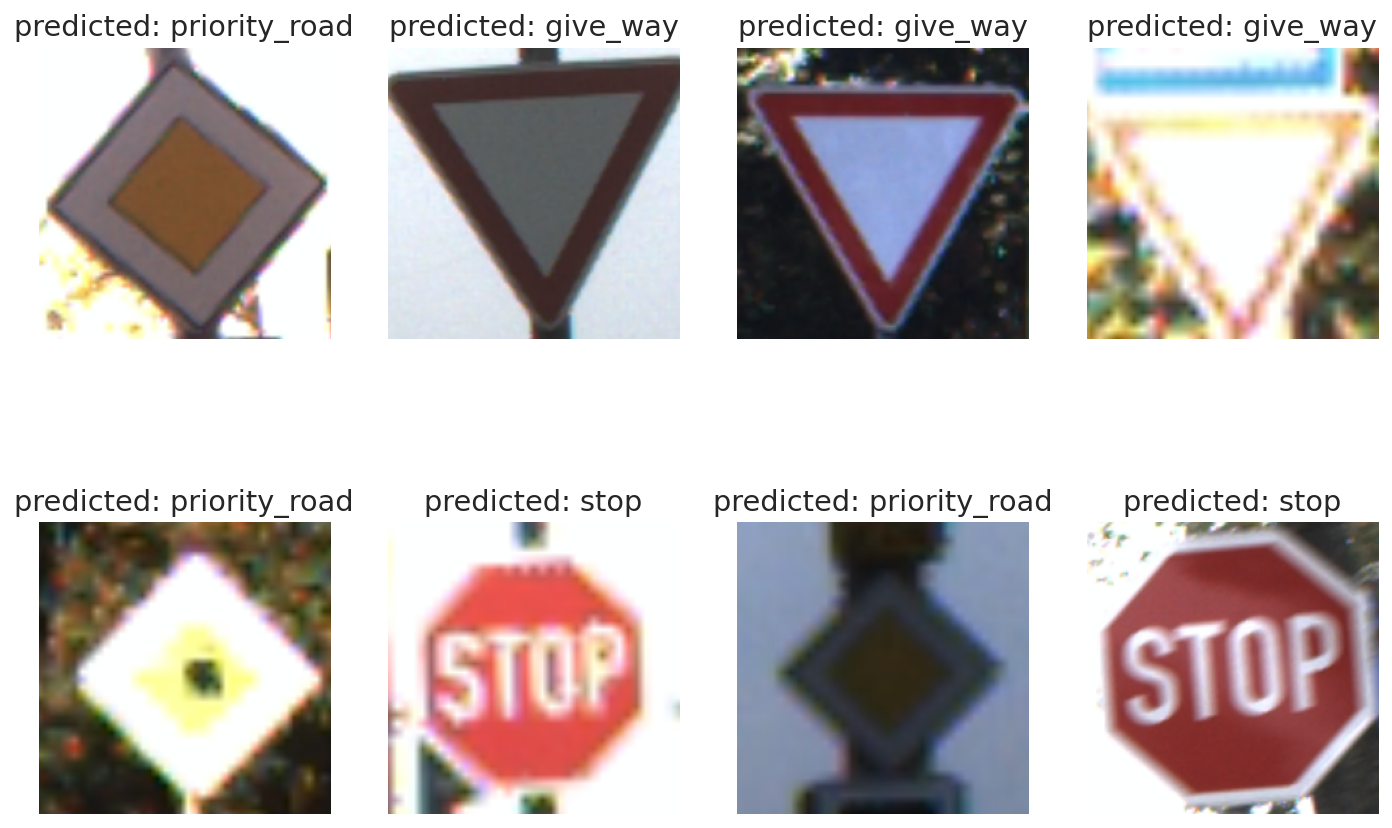

In [33]:
show_predictions(base_model, class_names, n_images=8)

Very good! Even the almost not visible *priority road* sign is classified correctly. Let's dive a bit deeper.

We'll start by getting the predictions from our model:

In [34]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [35]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [36]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



The classification report shows us that our model is perfect, not something you see every day! Does this thing make any mistakes?

In [37]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

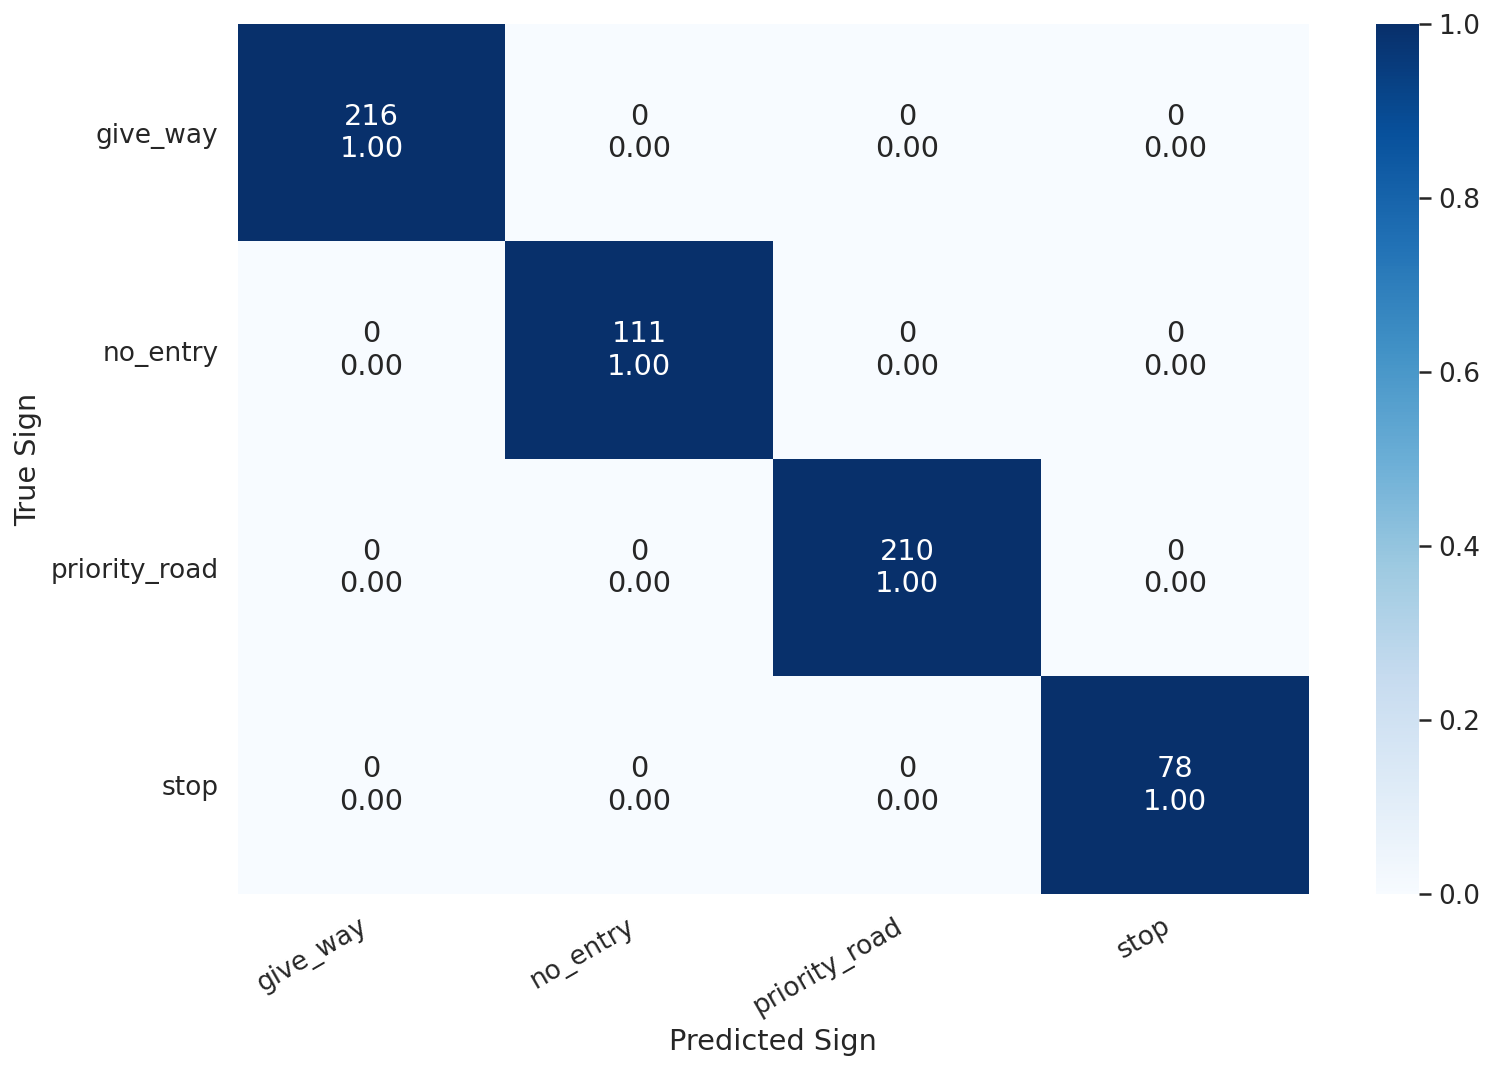

In [38]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

No, no mistakes here!

### Classifying unseen images

Ok, but how good our model will be when confronted with a real-world image? Let's check it out:

In [39]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 45.3MB/s]


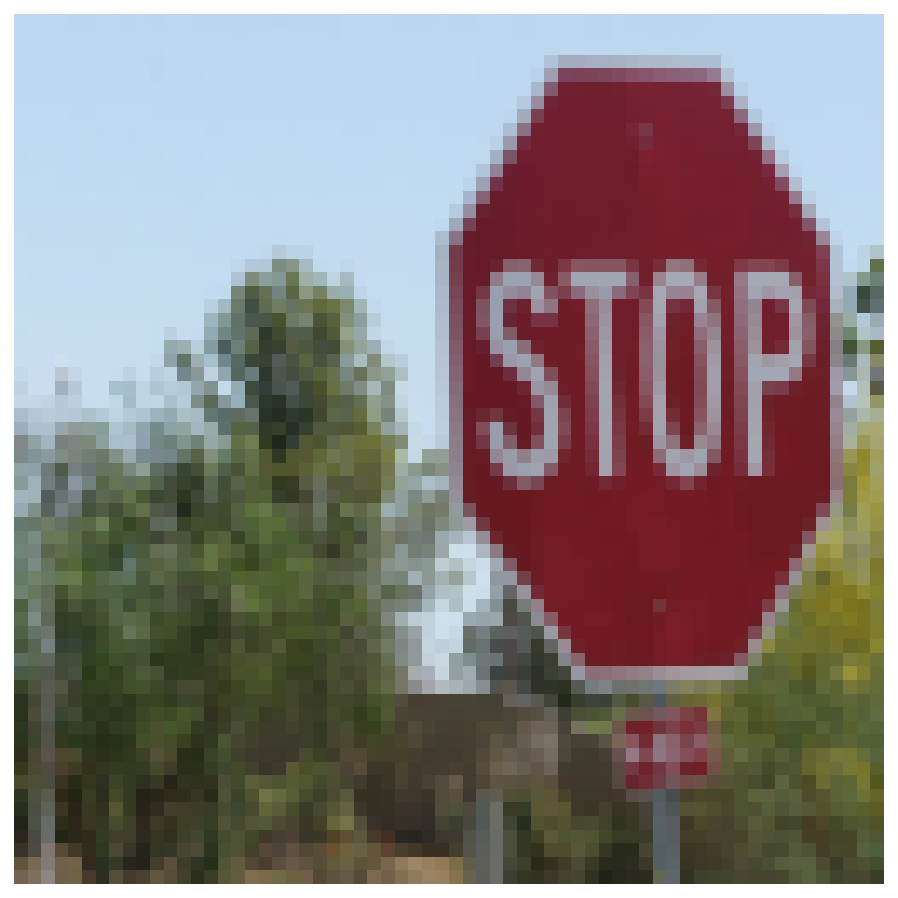

In [40]:
show_image('stop-sign.jpg')

For this, we'll have a look at the confidence for each class. Let's get this from our model:

In [41]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [42]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([1.21304565e-05, 3.70306952e-05, 5.12365077e-05, 9.99899507e-01],
      dtype=float32)

This is a bit hard to understand. Let's plot it:

In [43]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

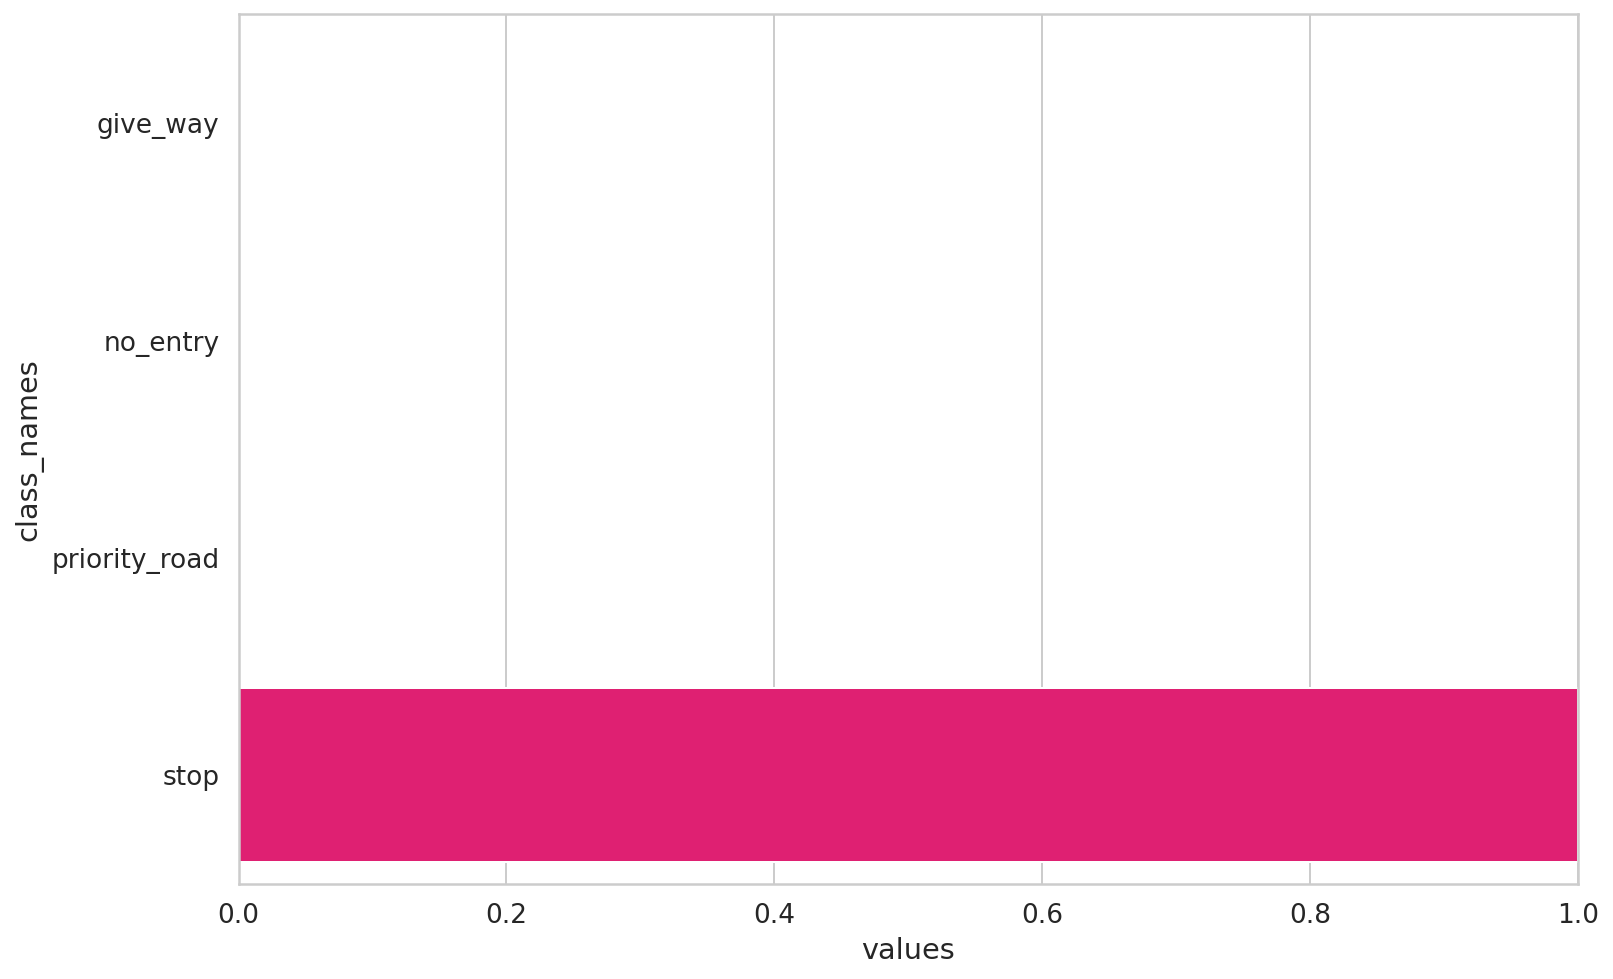

In [44]:
show_prediction_confidence(pred, class_names)

Again, our model is performing very well! Really confident in the correct traffic sign!

### Classyfing unknown traffic sign

The last challenge for our model is a traffic sign that it hasn't seen before:

In [45]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 32.9MB/s]


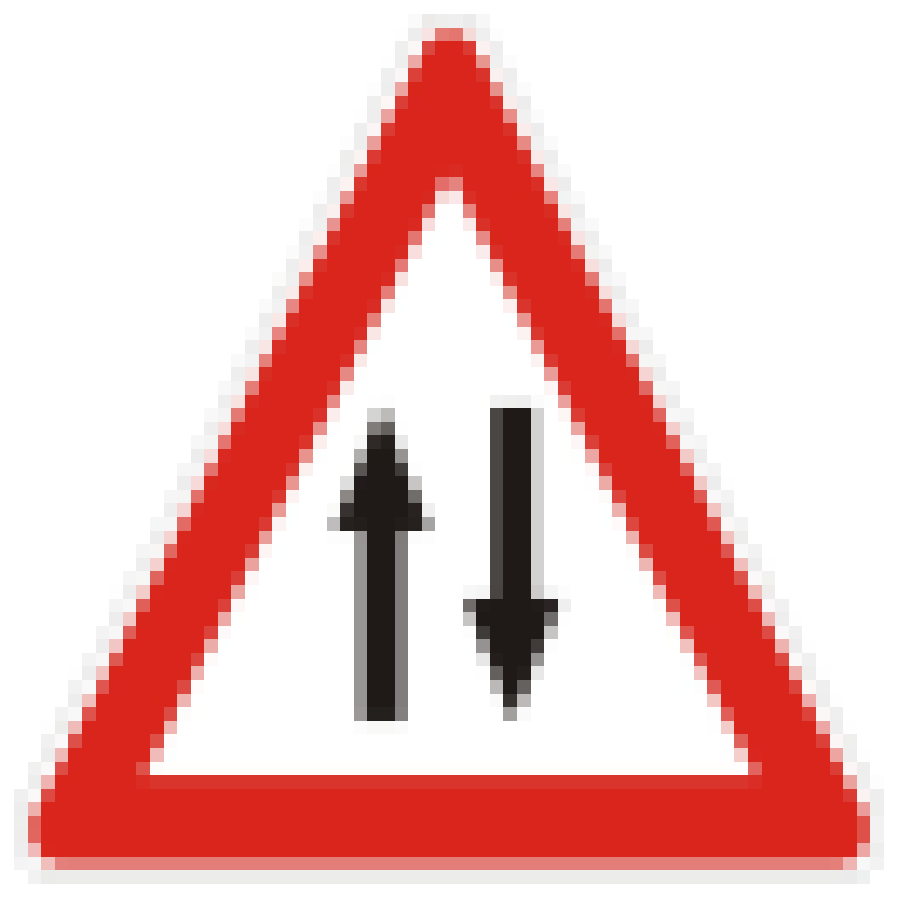

In [46]:
show_image('unknown-sign.jpg')

Let's get the predictions:

In [47]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([9.4068432e-01, 8.3528263e-05, 3.8388956e-02, 2.0843195e-02],
      dtype=float32)

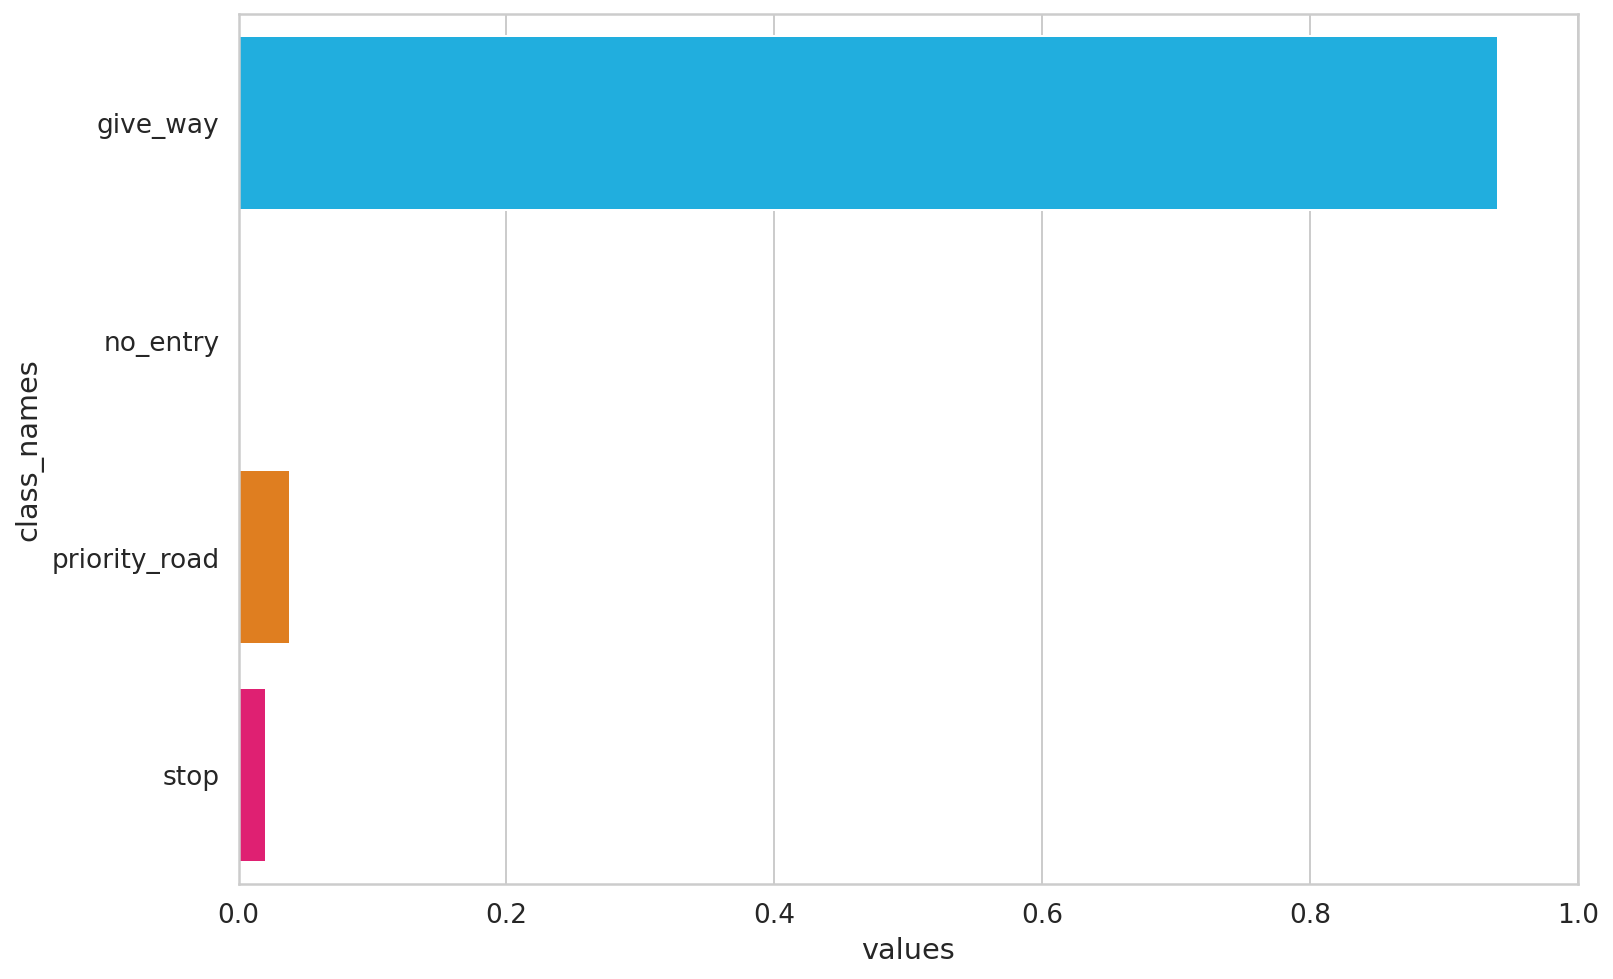

In [48]:
show_prediction_confidence(pred, class_names)

Our model is very certain (more than 95% confidence) that this is a *give way* sign. This is obviously wrong. How can you make your model see this?

## Adding class "unknown"

While there are a variety of ways to handle this situation (one described in this paper: [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](https://arxiv.org/pdf/1610.02136.pdf)), we'll do something simpler.

We'll get the indices of all traffic signs that weren't included in our original dataset:

In [49]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]

len(unknown_indices)

39

We'll create a new folder for the unknown class and copy some of the images there:

In [50]:
for ds in DATASETS:
  (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

The next steps are identical to what we've already done:

In [51]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 793, 'train': 5691, 'val': 786}

In [52]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.4128639422880992 accuracy 0.8601300298717273
Val   loss 0.01691776366687272 accuracy 0.9987277353689569

Epoch 2/3
----------
Train loss 0.17856141263180564 accuracy 0.9465823229660868
Val   loss 0.023748459284069198 accuracy 0.9910941475826973

Epoch 3/3
----------
Train loss 0.13211339857037274 accuracy 0.9592338780530663
Val   loss 0.00414581340743181 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 2min 15s, sys: 37.5 s, total: 2min 52s
Wall time: 2min 57s


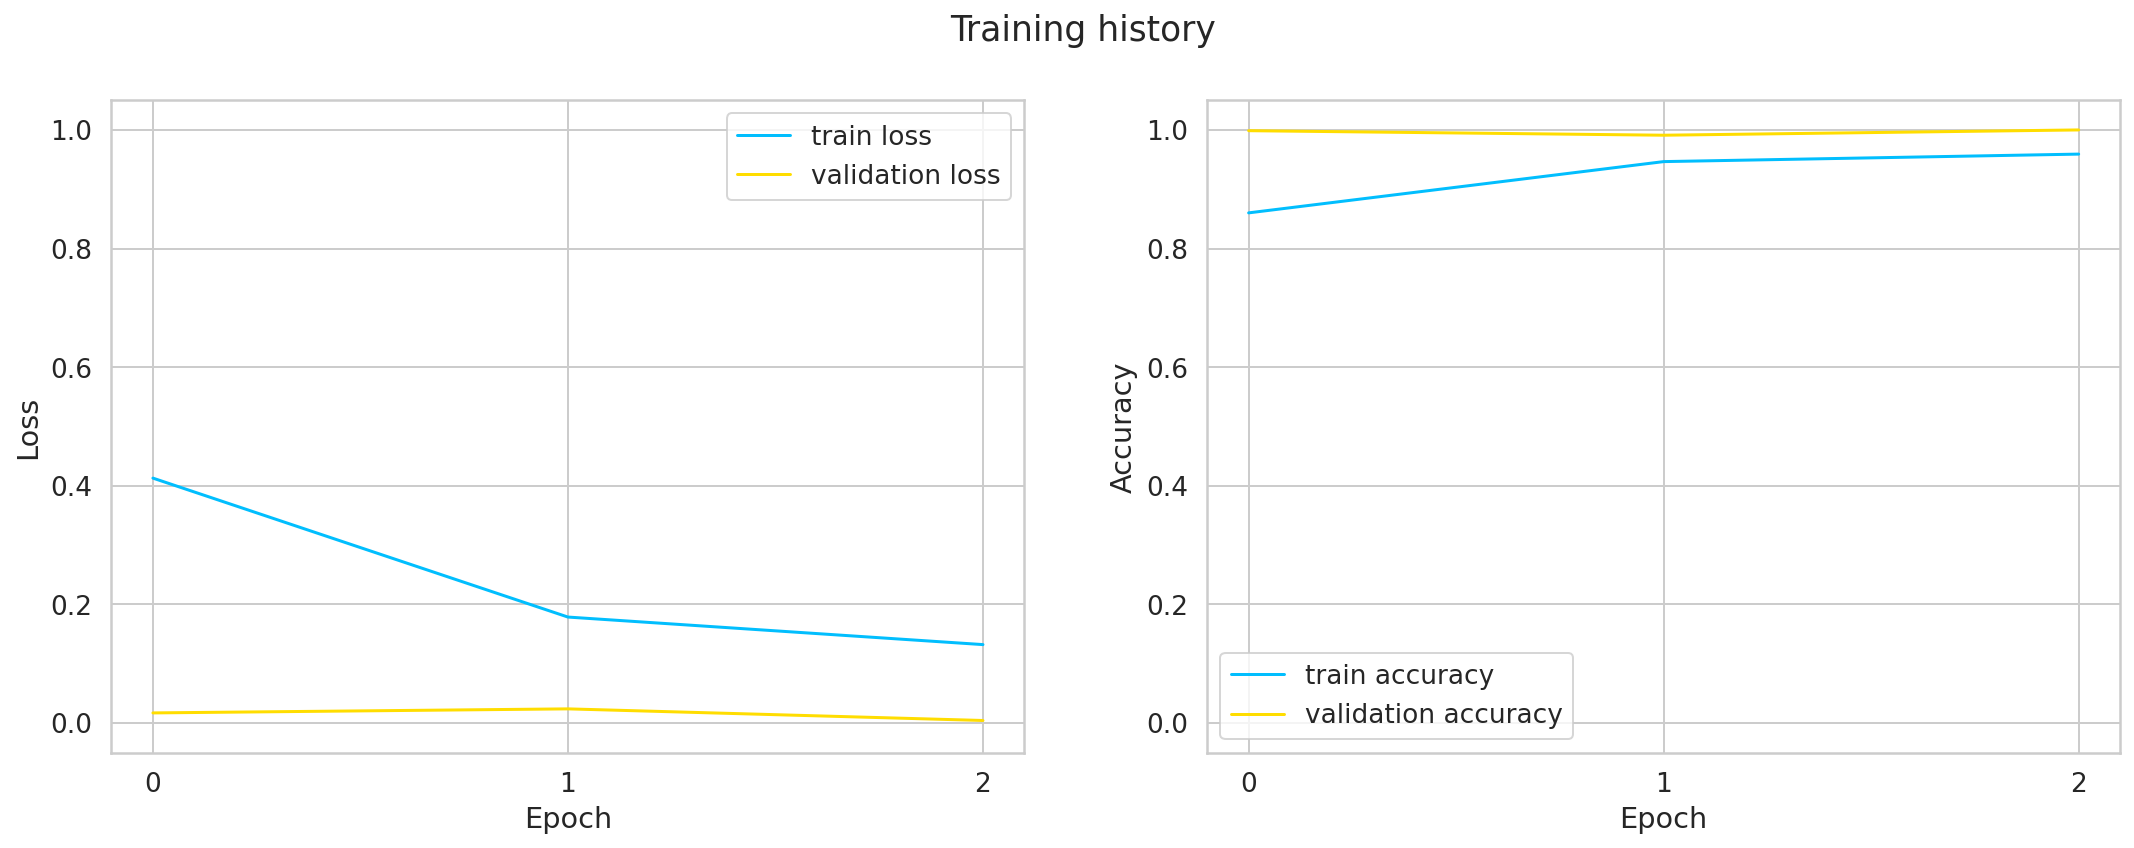

In [53]:
plot_training_history(history)

Again, our model is learning very quickly. Let's have a look at the sample image again:

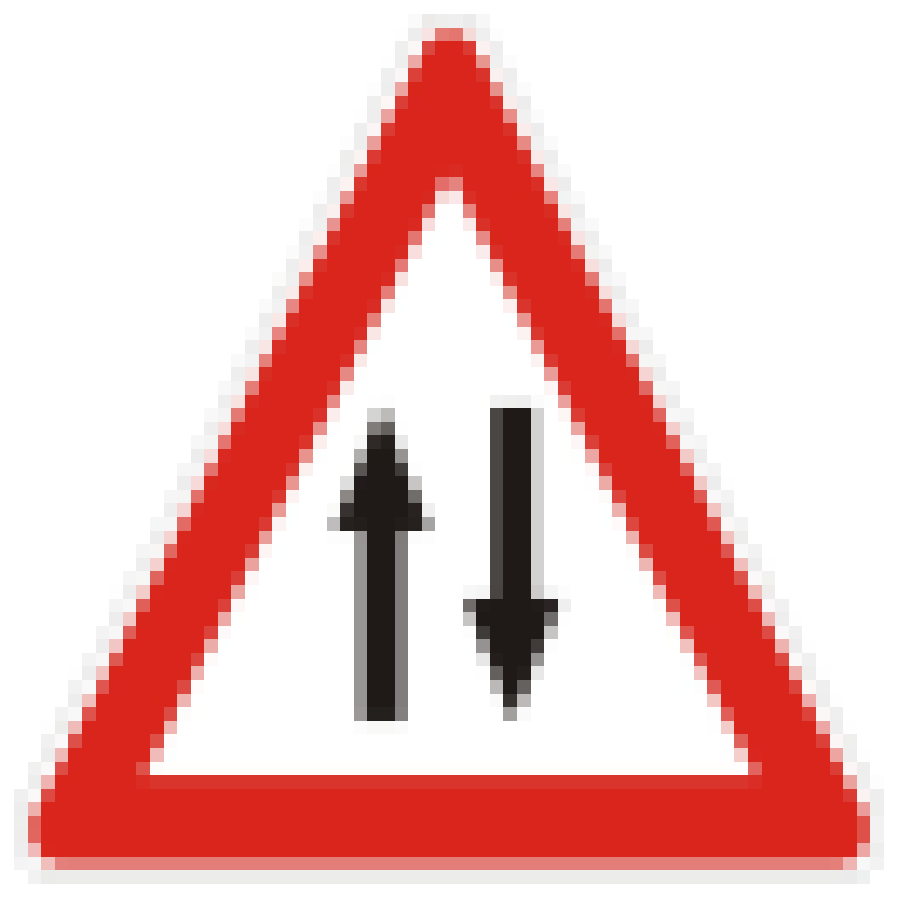

In [54]:
show_image('unknown-sign.jpg')

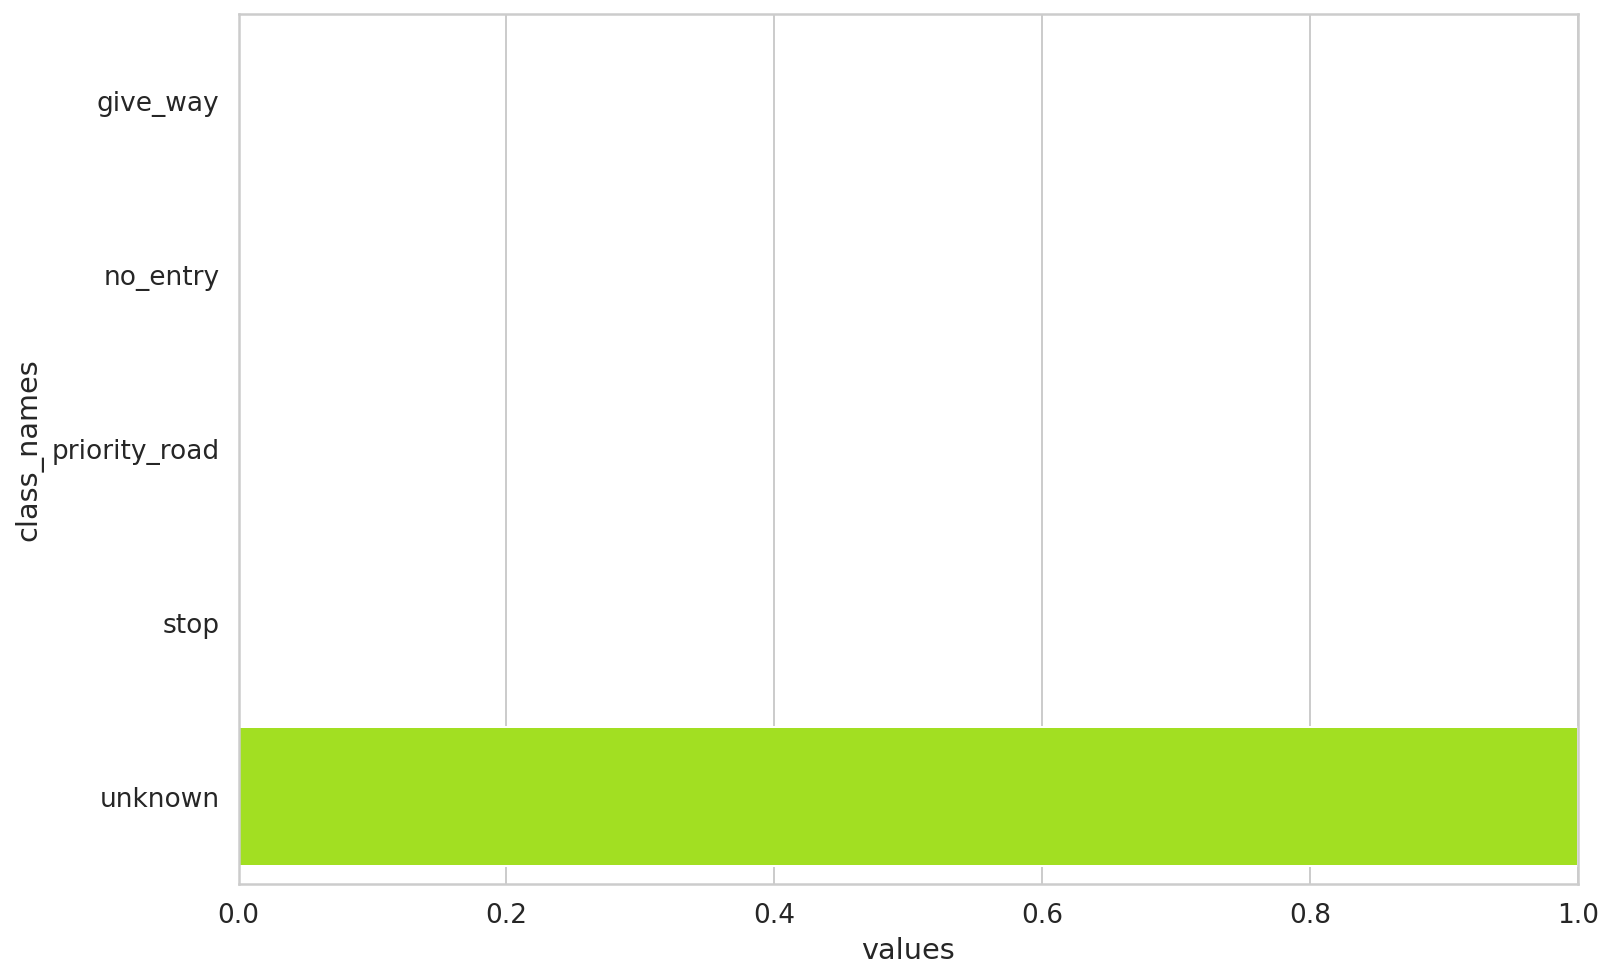

In [55]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

Great, the model doesn't give much weight to any of the known classes. It doesn't magically know that this is a two-way sign, but recognizes is as unknown.

Let's have a look at some examples of our new dataset:

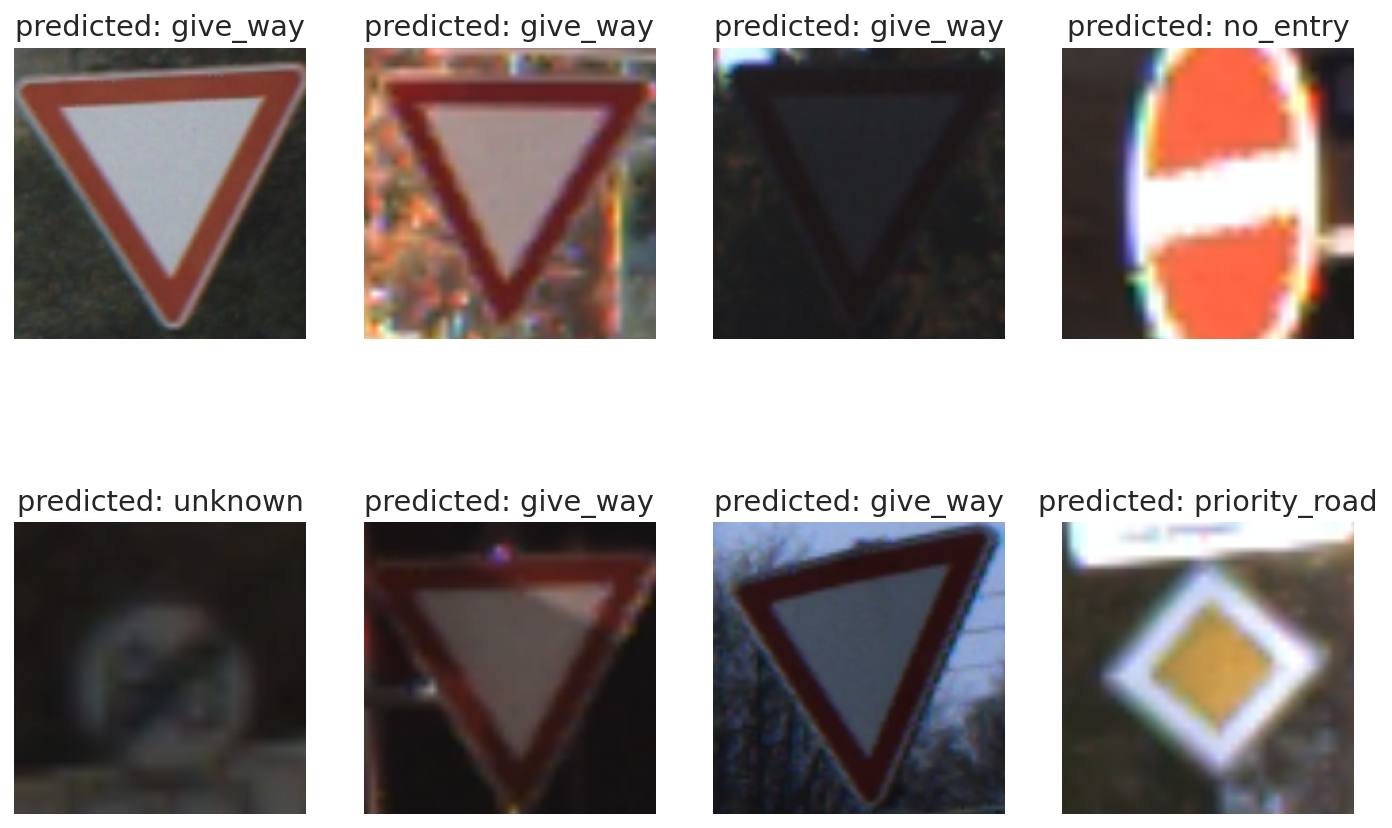

In [56]:
show_predictions(enchanced_model, class_names, n_images=8)

Let's get an overview of the new model's performance:

In [57]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

In [58]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78
      unknown       1.00      1.00      1.00       178

     accuracy                           1.00       793
    macro avg       1.00      1.00      1.00       793
 weighted avg       1.00      1.00      1.00       793



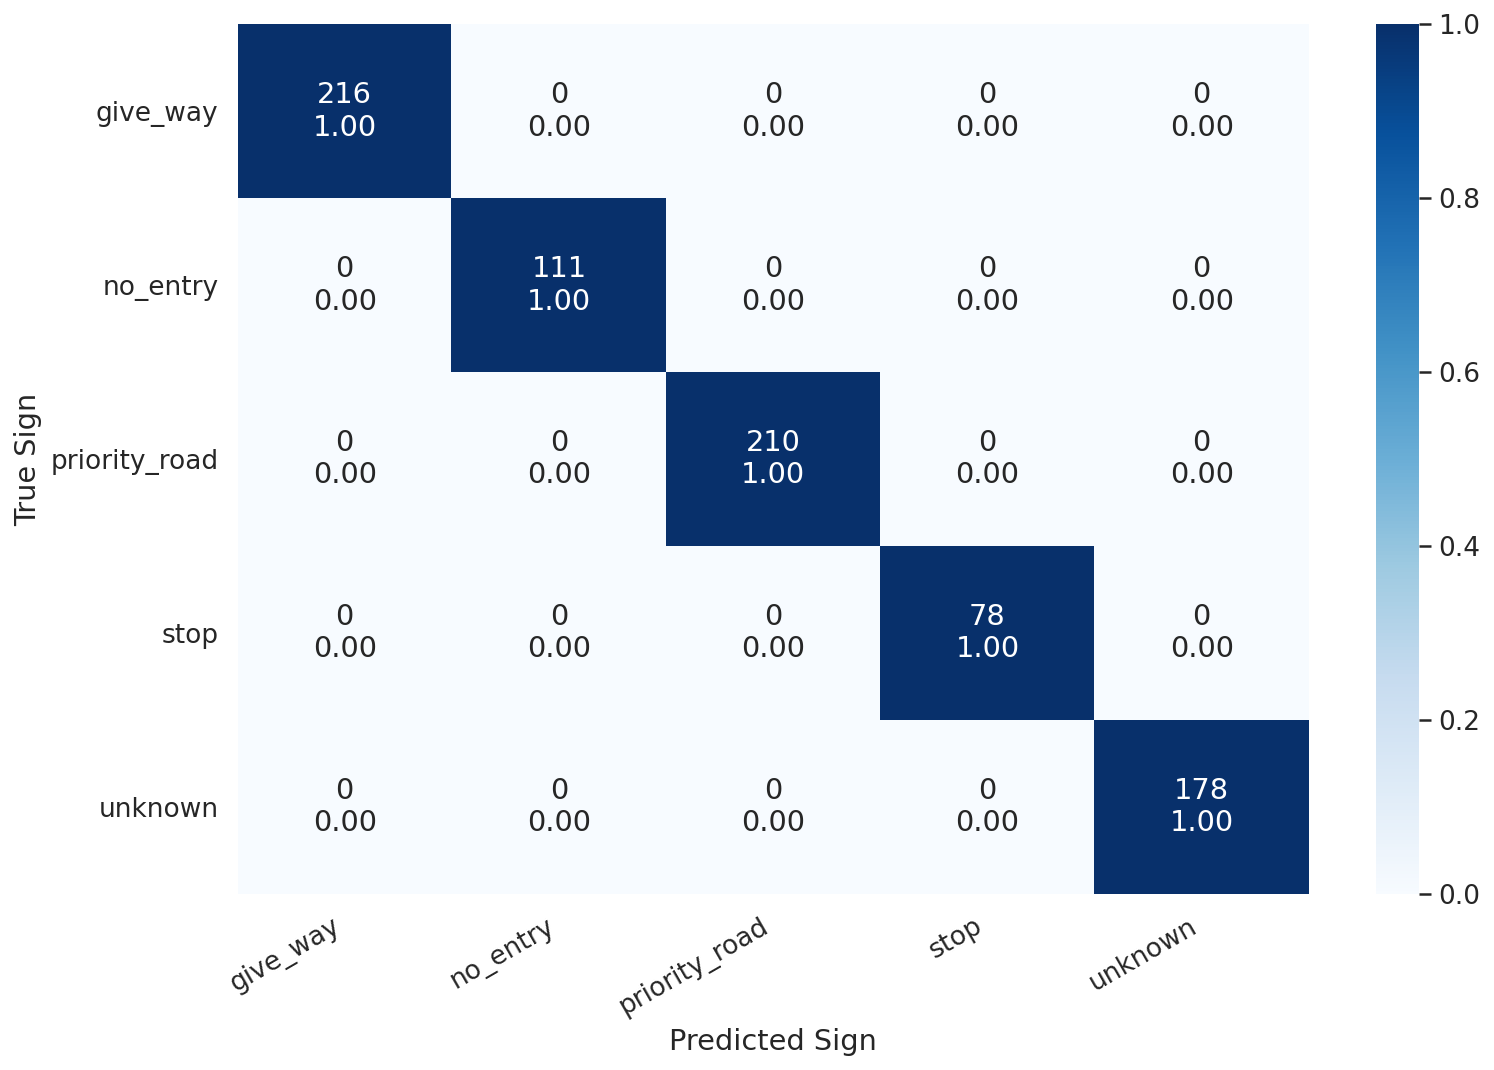

In [59]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

Our model is still perfect. Go ahead, try it on more images!

## Building a model

### Define a Convolutional Neural Network

Take 3-channel images.

In [112]:
BATCH_SIZE = 10
TRAIN_DATA_PATH = './data/train/'
TEST_DATA_PATH = './data/test/'
# TRANSFORM_IMG = T.Compose([
#     T.Resize(32),
#     T.CenterCrop(32),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
TRANSFORM_IMG = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# TRANSFORM_IMG_TRAIN = transforms['train']
# TRANSFORM_IMG_VAL = transforms['val']

train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Detected Classes are: ", train_data.class_to_idx)  # classes are detected by folder structure

Number of train samples:  5691
Number of test samples:  793
Detected Classes are:  {'give_way': 0, 'no_entry': 1, 'priority_road': 2, 'stop': 3, 'unknown': 4}


Some of the training images.



train_data_loader <class 'torch.utils.data.dataloader.DataLoader'>
images <class 'torch.Tensor'> 10
labels <class 'torch.Tensor'> 10 tensor([0, 1, 2, 0, 4, 4, 0, 1, 4, 4])
labels[0] tensor(0)
classes tensor([3, 2, 0, 1])
class_names[labels[0]] give_way


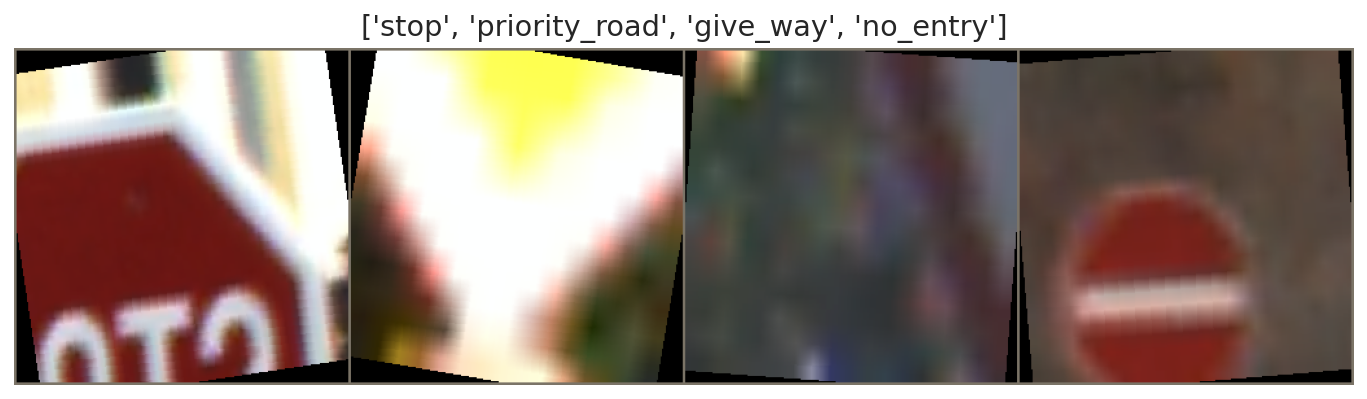

In [113]:
# import matplotlib.pyplot as plt
# import numpy as np

# functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# get some random training images
dataiter = iter(train_data_loader)
print('train_data_loader', type(train_data_loader))
images, labels = dataiter.next()
print('images', type(images), len(images))
print('labels', type(labels), len(labels), labels)
print('labels[0]', labels[0])
print('classes', classes)
print('class_names[labels[0]]', class_names[labels[0]])

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % class_names[labels[j]] for j in range(3)))


out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [60]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [69]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [76]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# import torch.utils.data as data
# import torchvision
# from torchvision import transforms


EPOCHS = 2
LEARNING_RATE = 0.003

# model = CNN()
# optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
# loss_func = nn.CrossEntropyLoss()

# Training and Testing
# for epoch in range(EPOCHS):
#     for step, (x, y) in enumerate(train_data_loader):
#         b_x = Variable(x)   # batch x (image)
#         b_y = Variable(y)   # batch y (target)
#         output = net(b_x)[0]
#         loss = loss_func(output, b_y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if step % 50 == 0:
#             test_x = Variable(test_data_loader)
#             test_output, last_layer = net(test_x)
#             pred_y = torch.max(test_output, 1)[1].data.squeeze()
#             accuracy = sum(pred_y == test_y) / float(test_y.size(0))
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)


Number of train samples:  5691
Number of test samples:  793
Detected Classes are:  {'give_way': 0, 'no_entry': 1, 'priority_road': 2, 'stop': 3, 'unknown': 4}


In [77]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.003
[1,   400] loss: 0.006
[2,   200] loss: 0.004
[2,   400] loss: 0.005
Finished Training


Save our trained model

In [67]:
# PATH = './my_net.pth'
# torch.save(net.state_dict(), PATH)

## Test the network

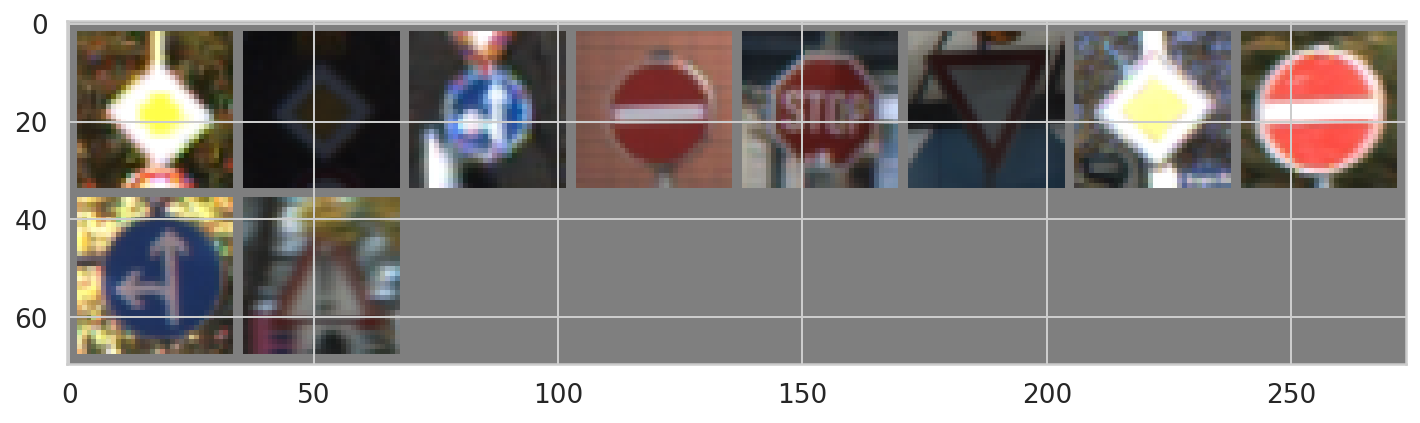

GroundTruth:  priority_road priority_road unknown no_entry  stop give_way priority_road no_entry


In [107]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(8)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [78]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [92]:
outputs = net(images)
# print('outputs', outputs)

outputs tensor([[ 11.8994,  -4.0778,  -3.0205,  -4.8175,   2.1255, -13.2142, -14.0739,
         -13.0122, -13.9601, -13.8235],
        [-13.4207,  29.2443,  -3.4303,   4.4169,  -1.5432, -51.8449, -43.4855,
         -53.5327, -46.9885, -46.9537],
        [-20.0416,  40.5034,  -7.1091,   7.5132,  -3.9501, -71.7060, -59.9433,
         -73.2575, -64.5084, -64.8348]], grad_fn=<AddmmBackward>)


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [103]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(3)))

predicted tensor([0, 1, 1])
Predicted:  give_way no_entry no_entry


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [85]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [88]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of tensor(1) : 100 %
Accuracy of tensor(3) : 100 %
Accuracy of tensor(3) : 100 %
Accuracy of tensor(3) : 100 %


IndexError: ignored